In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyodbc
import openpyxl

In [ ]:
fpd = pd.read_csv('/Users/starsrain/2025_concord/yieldCurve_augmenting/projection_data/fpd_1106.csv')
data = pd.read_csv('/Users/starsrain/2025_concord/yieldCurve_augmenting/projection_data/data_1106.csv')

In [3]:
data.head()

,Application_ID,PortFolioID,LoanID,Frequency,LPCampaign,OriginatedAmount,OrigYear,OrigMonth,OrigWeek,OriginationDate,...,TransactionDate,PmtYear,PmtMonth,Days_Since_Orig,Weeks_Since_Orig,PaymentType,Payment_Number,PaymentStatus,weeks_between_orig_now,CustType
0,99678497,6,I1912769-0,B,RTRNGD,400.0,2024.0,1.0,1.0,2024-01-01 03:15:29.720,...,2024-01-05 07:34:30.210,2024.0,1.0,4.0,1.0,Installment Pmt,1,R,96.0,REPEAT
1,99678497,6,I1912769-0,B,RTRNGD,400.0,2024.0,1.0,1.0,2024-01-01 03:15:29.720,...,2024-01-05 08:11:13.350,2024.0,1.0,4.0,1.0,Installment Pmt,2,D,96.0,REPEAT
2,99678497,6,I1912769-0,B,RTRNGD,400.0,2024.0,1.0,1.0,2024-01-01 03:15:29.720,...,2024-01-17 14:12:23.833,2024.0,1.0,16.0,3.0,Installment Pmt,3,D,96.0,REPEAT
3,99678497,6,I1912769-0,B,RTRNGD,400.0,2024.0,1.0,1.0,2024-01-01 03:15:29.720,...,2024-02-02 07:14:24.553,2024.0,2.0,32.0,5.0,Installment Pmt,4,D,96.0,REPEAT
4,99678497,6,I1912769-0,B,RTRNGD,400.0,2024.0,1.0,1.0,2024-01-01 03:15:29.720,...,2024-02-16 07:45:37.937,2024.0,2.0,46.0,7.0,Installment Pmt,5,D,96.0,REPEAT


### Basic setup and helper functions

In [4]:
def compute_daily_yield(data):
    """
    Compute daily cumulative yield correctly:
    1. Get unique loans and their original amounts (avoid double counting)
    2. For each day since origination, sum all payments made up to that day
    3. Calculate yield as cumulative_payments / total_originated_amount
    """
    if data.empty:
        return pd.Series(dtype=float)
    
    # Get unique loans and their amounts (avoid double counting from multiple installments)
    loan_amounts = data.groupby('LoanID')['OriginatedAmount'].first()
    total_originated = loan_amounts.sum()
    
    # Group by Days_Since_Orig and sum payments for each day
    daily_payments = data.groupby('Days_Since_Orig')['PaidOffPaymentAmount'].sum()
    
    # Create cumulative sum of payments
    cumulative_payments = daily_payments.cumsum()
    
    # Calculate yield as cumulative payments / total originated
    yield_curve = cumulative_payments / total_originated
    
    return yield_curve

def prepare_df_strict(df):
    """Prepare dataframe with strict data cleaning"""
    df = df.copy()
    df = df[df['PaymentStatus'] != 'R']
    # Convert date columns
    date_cols = ['OriginationDate', 'DueDate']
    for col in date_cols:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')
    
    # Drop rows with missing critical fields
    critical_fields = ['LoanID', 'OriginatedAmount', 'InstallmentNumber']
    initial_count = len(df)
    df = df.dropna(subset=critical_fields)
    dropped = initial_count - len(df)
    if dropped > 0:
        print(f"[prepare] Dropped {dropped} rows with missing critical fields")

    
    # Create cohort from origination date
    df['Cohort'] = df['OriginationDate'].dt.to_period('M').astype(str)
    
    # Ensure CustType exists
    if 'CustType' not in df.columns:
        df['CustType'] = 'Unknown'
    before_dedup = len(df)
    df = df.drop_duplicates(subset=['LoanID', 'InstallmentNumber', 'DueDate', 'PaidOffPaymentAmount'])
    after_dedup = len(df)
    if before_dedup != after_dedup:
        print(f"[prepare] Removed {before_dedup - after_dedup} duplicate records")

    
    return df

# Updated plotting function with proper data cleaning and filtering
def plot_frequency_yield_curves_corrected(data, months, max_days=200, annotate_days=None):
    """
    Plot yield curves with correct filtering and calculation:
    1. Apply proper data cleaning (remove 'R' status, deduplicate, etc.)
    2. Filter DueDate <= today
    3. Group by frequency and origination month  
    4. Calculate daily yield correctly
    """
    
    if annotate_days is None:
        annotate_days = [30, 60, 90, 120, 150, 180]
    
    # Step 1: Apply proper data cleaning using existing function
    print("Step 1: Cleaning data...")
    df_cleaned = prepare_df_strict(data)
    
    # Step 2: Filter out loans with DueDate > today
    today = pd.Timestamp.now().normalize()
    print(f"Step 2: Filtering DueDate <= {today.date()}")
    
    initial_count = len(df_cleaned)
    df_filtered = df_cleaned[df_cleaned['DueDate'] <= today].copy()
    print(f"Kept {len(df_filtered):,}/{initial_count:,} records with DueDate <= today")
    
    # Step 3: Filter to requested origination months
    df_filtered = df_filtered[df_filtered['Cohort'].isin(months)]
    
    # Step 4: Remove any rows with missing critical data for yield calculation
    df_filtered = df_filtered.dropna(subset=['LoanID', 'OriginatedAmount', 'PaidOffPaymentAmount', 'Days_Since_Orig', 'Frequency'])
    
    print(f"Final dataset: {len(df_filtered):,} records, {df_filtered['LoanID'].nunique():,} unique loans")
    
    # Define frequency groups
    freq_groups = {
        'Weekly': ['W'],
        'Biweekly': ['B'],
        'Monthly_Benefits': ['MB'],
        'Monthly_Expenses': ['ME']
    }
    
    fig, axes = plt.subplots(1, len(freq_groups), figsize=(6*len(freq_groups), 6), sharey=True)
    if len(freq_groups) == 1:
        axes = [axes]
    
    # Colors for months
    palette = plt.get_cmap('tab10')
    month_colors = {m: palette(i % 10) for i, m in enumerate(months)}
    
    curves = {}
    
    print(f"\nYield Curves for months: {', '.join(months)}")
    print('='*80)
    
    for ax, (freq_name, freq_codes) in zip(axes, freq_groups.items()):
        ax.set_title(f"{freq_name} Loans", fontsize=14, fontweight='bold')
        ax.set_xlabel('Days Since Origination')
        ax.grid(True, alpha=0.3)
        
        freq_has_data = False
        
        for month in months:
            # Filter for this month and frequency
            subset = df_filtered[
                (df_filtered['Cohort'] == month) & 
                (df_filtered['Frequency'].isin(freq_codes))
            ].copy()
            
            if subset.empty:
                continue
                
            loan_count = subset['LoanID'].nunique()
            freq_has_data = True
            
            # Calculate yield curve
            curve = compute_daily_yield(subset)
            curves.setdefault(month, {})[freq_name] = curve.copy()
            
            # Plot curve
            ax.plot(curve.index, curve.values, 
                   label=f"{month} (n={loan_count:,})", 
                   color=month_colors[month], linewidth=2)
            for d in annotate_days:
                if d in curve.index:
                    ax.text(d, curve[d], f"{curve[d]:.2f}", 
                           fontsize=8, color=month_colors[month], 
                           ha='center', va='bottom')
            
            # Print summary
            summary_vals = []
            for d in annotate_days:
                if d in curve.index:
                    summary_vals.append(f"{d}d={curve[d]:.3f}")
            print(f"  {freq_name:17s} | {month} | loans={loan_count:,} | " + ', '.join(summary_vals))
        
        if not freq_has_data:
            ax.text(0.5, 0.5, 'No Data', transform=ax.transAxes, 
                   ha='center', va='center', fontsize=12, color='gray')
        
        # Format axes
        ax.axhline(1.0, color='red', linestyle='--', alpha=0.5, label='Target = 1.0')
        ax.set_xlim(0, max_days)
        ax.set_ylim(0, 1.8)
        ax.set_yticks(np.arange(0, 1.9, 0.1))
        ax.legend(fontsize=10, loc='lower right')
    
    axes[0].set_ylabel('Cumulative Yield (Paid / Originated)')
    fig.suptitle('Corrected Cumulative Yield Curves by Frequency', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return curves


In [5]:
def create_payin_tables_by_frequency(df, cohorts, cap=1.70):
    """
    Create payin ratio tables by InstallmentNumber for different loan frequencies
    - Apply proper data cleaning (remove 'R' status, deduplicate, etc.)
    - Filter out loans with DueDate > today
    - Return three tables for Weekly, Biweekly, and Monthly (MB+ME combined)
    - NON-CUMULATIVE: Shows payin ratio for each individual installment
    Returns: Dictionary with tables for each frequency
    """
    
    # Step 1: Apply proper data cleaning
    print("Step 1: Cleaning data...")
    df_prepared = prepare_df_strict(df)
    
    # Step 2: Filter out loans with DueDate > today
    today = pd.Timestamp.now().normalize()
    print(f"Step 2: Filtering DueDate <= {today.date()}")
    
    initial_count = len(df_prepared)
    df_filtered = df_prepared[df_prepared['DueDate'] <= today].copy()
    print(f"Kept {len(df_filtered):,}/{initial_count:,} records with DueDate <= today")
    
    # Step 3: Filter to requested cohorts
    df_filtered = df_filtered[df_filtered['Cohort'].isin(cohorts)]
    print(f"Final dataset for cohorts {cohorts}: {len(df_filtered):,} records, {df_filtered['LoanID'].nunique():,} unique loans")
    
    frequency_mappings = {
        'Weekly_fpd': ['W'],
        'Biweekly_fpd': ['B'], 
        'Monthly_fpd': ['MB', 'ME']  
    }
    
    frequency_tables = {}
    
    for freq_name, freq_types in frequency_mappings.items():
        print(f"\nProcessing {freq_name}...")
        
        # Collect data for all cohorts for this frequency
        all_cohort_data = []
        
        for cohort in cohorts:
            # Filter data for this cohort and frequency types
            cohort_data = df_filtered[df_filtered['Cohort'] == cohort].copy()
            cohort_data = cohort_data[cohort_data['Frequency'].isin(freq_types)]
            
            if cohort_data.empty:
                continue
            
            # Aggregate payments by loan and installment
            per_installment = (cohort_data.groupby(['LoanID', 'InstallmentNumber'], as_index=False)
                             .agg(PaidThisInstallment=('PaidOffPaymentAmount', 'sum'),
                                  OriginatedAmount=('OriginatedAmount', 'first')))
            
            # Calculate NON-CUMULATIVE payin ratio (payment for this installment only)
            per_installment['InstallmentPayinRatio'] = (per_installment['PaidThisInstallment'] / per_installment['OriginatedAmount']).clip(upper=cap)
            
            # Calculate weighted average payin ratio by installment (NON-CUMULATIVE)
            installment_curve = (per_installment.groupby('InstallmentNumber')[['InstallmentPayinRatio','OriginatedAmount']]
                               .apply(lambda x: np.average(x['InstallmentPayinRatio'], weights=x['OriginatedAmount']))
                               .reset_index(name='PayinRatio'))
            installment_curve.columns = ['InstallmentNumber', 'PayinRatio']
            
            # Add OrigMonth (cohort) information
            installment_curve['OrigMonth'] = cohort
            
            # Add to collection
            all_cohort_data.append(installment_curve)
        
        if all_cohort_data:
            # Combine all cohorts for this frequency
            combined_table = pd.concat(all_cohort_data, ignore_index=True)
            
            # Sort by OrigMonth and InstallmentNumber
            combined_table = combined_table.sort_values(['OrigMonth', 'InstallmentNumber']).reset_index(drop=True)
            
            # Reorder columns: InstallmentNumber, OrigMonth, PayinRatio
            combined_table = combined_table[['InstallmentNumber', 'OrigMonth', 'PayinRatio']]
            
            frequency_tables[freq_name] = combined_table
            
            print(f"Created table for {freq_name}: {len(combined_table)} rows")
            print(f"InstallmentNumber range: {combined_table['InstallmentNumber'].min()} to {combined_table['InstallmentNumber'].max()}")
            print(f"OrigMonth values: {sorted(combined_table['OrigMonth'].unique())}")
            print(f"Sample data:")
            print(combined_table.head())
        else:
            print(f"No data found for {freq_name}")
    
    return frequency_tables

### data preparation 

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import scipy.stats as stats

print("=== COMPREHENSIVE TRAIN/TEST REGRESSION ANALYSIS ===")
print("Using ALL cohorts, proper train/test split, and performance evaluation")
print("="*70)

# Step 1: Create comprehensive payin tables
def create_all_cohort_payin_tables(df, cap=1.70):
    """Create payin tables using ALL available cohorts"""
    print("Creating payin tables with ALL cohorts...")
    
    # Apply data cleaning but NO cohort filtering
    df_prepared = prepare_df_strict(df)
    print(f"Using ALL data without DueDate filtering: {df_prepared.shape}")
    
    frequency_mappings = {
        'Weekly_fpd': ['W'],
        'Biweekly_fpd': ['B'], 
        'Monthly_fpd': ['MB', 'ME']  
    }
    
    all_frequency_tables = {}
    
    for freq_name, freq_types in frequency_mappings.items():
        print(f"\nProcessing {freq_name} with all cohorts...")
        
        freq_data = df_prepared[df_prepared['Frequency'].isin(freq_types)].copy()
        
        if freq_data.empty:
            print(f"No data found for {freq_name}")
            continue
        
        print(f"Found {freq_data.shape[0]} records for {freq_name}")
        print(f"Cohorts in this frequency: {sorted(freq_data['Cohort'].unique())}")
        print(f"Installment range: {freq_data['InstallmentNumber'].min()} to {freq_data['InstallmentNumber'].max()}")
        
        # Aggregate payments by loan and installment
        per_installment = (freq_data.groupby(['LoanID', 'InstallmentNumber'], as_index=False)
                         .agg(PaidThisInstallment=('PaidOffPaymentAmount', 'sum'),
                              OriginatedAmount=('OriginatedAmount', 'first'),
                              Cohort=('Cohort', 'first')))
        
        # Calculate NON-CUMULATIVE payin ratio
        per_installment['InstallmentPayinRatio'] = (per_installment['PaidThisInstallment'] / per_installment['OriginatedAmount']).clip(upper=cap)
        
        # Calculate weighted payin ratio and carry TotalOrig by cohort and installment
        installment_curve = []
        for cohort in per_installment['Cohort'].unique():
            cohort_data = per_installment[per_installment['Cohort'] == cohort]
            agg = (cohort_data.groupby('InstallmentNumber', as_index=False)
                   .agg(PaidSum=('PaidThisInstallment','sum'),
                        TotalOrig=('OriginatedAmount','sum')))
            cohort_curve = agg[['InstallmentNumber']].copy()
            cohort_curve['PayinRatio'] = (agg['PaidSum'] / agg['TotalOrig']).clip(upper=cap)
            cohort_curve['OrigMonth'] = cohort
            cohort_curve['TotalOrig'] = agg['TotalOrig']
            installment_curve.append(cohort_curve)
        
        if installment_curve:
            combined_table = pd.concat(installment_curve, ignore_index=True)
            combined_table = combined_table.sort_values(['OrigMonth', 'InstallmentNumber']).reset_index(drop=True)
            combined_table = combined_table[['InstallmentNumber', 'OrigMonth', 'PayinRatio', 'TotalOrig']]
            
            all_frequency_tables[freq_name] = combined_table
            print(f"Created table for {freq_name}: {len(combined_table)} rows")
        else:
            print(f"No data found for {freq_name}")
    
    return all_frequency_tables

all_payin_tables = create_all_cohort_payin_tables(data, cap=1.70)

# Step 2: Merge with FPD data and create comprehensive datasets
print(f"\n{'='*70}")
print("CREATING COMPREHENSIVE DATASETS WITH FPD MERGE")
print(f"{'='*70}")

fpd_last_3_cols = fpd.columns[-3:].tolist()
default_rate_col = 'FPDFA_rate'

comprehensive_datasets = {}

for freq_name, freq_codes in [('Biweekly', ['B']), ('Weekly', ['W']), ('Monthly', ['MB', 'ME'])]:
    table_key = f"{freq_name}_fpd"
    
    if table_key in all_payin_tables:
        print(f"\nProcessing {freq_name}...")

        payin_table = all_payin_tables[table_key].copy()
        fpd_source = fpd[fpd['Frequency'].isin(freq_codes)][['OrigMonth', 'InstallmentNumber'] + fpd_last_3_cols].copy()
        payin_table['OrigMonth'] = payin_table['OrigMonth'].astype(str)
        payin_table['InstallmentNumber'] = payin_table['InstallmentNumber'].astype(int)
        fpd_source['OrigMonth'] = fpd_source['OrigMonth'].astype(str)
        fpd_source['InstallmentNumber'] = fpd_source['InstallmentNumber'].astype(int)

        merged_data = payin_table.merge(fpd_source, on=['OrigMonth', 'InstallmentNumber'], how='left')
        
        # Only keep records with valid default rate data
        if default_rate_col in merged_data.columns:
            clean_data = merged_data.dropna(subset=['PayinRatio', 'InstallmentNumber', default_rate_col]).copy()
            
            if len(clean_data) >= 10:
                comprehensive_datasets[freq_name] = clean_data
                print(f"{freq_name}: {len(clean_data)} complete records")
                print(f"  Cohort range: {clean_data['OrigMonth'].min()} to {clean_data['OrigMonth'].max()}")
                print(f"  Installment range: {clean_data['InstallmentNumber'].min()} to {clean_data['InstallmentNumber'].max()}")
                print(f"  Default rate range: {clean_data[default_rate_col].min():.4f} to {clean_data[default_rate_col].max():.4f}")
            else:
                print(f"{freq_name}: Insufficient data ({len(clean_data)} points)")
        else:
            print(f"{freq_name}: Default rate column '{default_rate_col}' not found")

=== COMPREHENSIVE TRAIN/TEST REGRESSION ANALYSIS ===
Using ALL cohorts, proper train/test split, and performance evaluation
Creating payin tables with ALL cohorts...
[prepare] Removed 8057 duplicate records
Using ALL data without DueDate filtering: (449458, 27)

Processing Weekly_fpd with all cohorts...
Found 88988 records for Weekly_fpd
Cohorts in this frequency: ['2024-01', '2024-02', '2024-03', '2024-04', '2024-05', '2024-06', '2024-07', '2024-08', '2024-09', '2024-10', '2024-11', '2024-12', '2025-01', '2025-02', '2025-03', '2025-04', '2025-05', '2025-06', '2025-07', '2025-08', '2025-09', '2025-10', 'NaT']
Installment range: 1 to 148
Created table for Weekly_fpd: 731 rows

Processing Biweekly_fpd with all cohorts...
Found 309065 records for Biweekly_fpd
Cohorts in this frequency: ['2024-01', '2024-02', '2024-03', '2024-04', '2024-05', '2024-06', '2024-07', '2024-08', '2024-09', '2024-10', '2024-11', '2024-12', '2025-01', '2025-02', '2025-03', '2025-04', '2025-05', '2025-06', '2025-0

### Models

#### Model running V1

In [10]:
# === Time-based split regression (weighted by TotalOrig), reusing comprehensive_datasets ===
# This augments the first regression by splitting train/test by OrigMonth order
# and fits an unweighted LinearRegression on [InstallmentNumber, FPDFA_rate].

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd

print("\n=== Unweighted modeling with time-based split (by OrigMonth) ===")

if not comprehensive_datasets:
    raise RuntimeError("comprehensive_datasets is empty. Run the earlier cell that builds it.")

time_split_results = {}
SPLIT_RATIO = 0.7

for freq_name, dataset in comprehensive_datasets.items():
    dfm = dataset.copy()
    # ensure correct dtypes
    dfm['OrigMonth'] = dfm['OrigMonth'].astype(str)
    dfm['InstallmentNumber'] = dfm['InstallmentNumber'].astype(int)

    # Time-based split by month (first 70% months train, last 30% test)
    dfm['_month'] = pd.PeriodIndex(dfm['OrigMonth'], freq='M')
    months = np.array(sorted(dfm['_month'].unique()))
    if len(months) < 2:
        print(f"{freq_name}: insufficient distinct months ({len(months)}); skipping")
        continue
    cut_idx = max(1, int(np.floor(len(months) * SPLIT_RATIO)))
    train_months = set(months[:cut_idx])
    test_months  = set(months[cut_idx:])

    train_mask = dfm['_month'].isin(train_months)
    test_mask  = dfm['_month'].isin(test_months)

    X_train = dfm.loc[train_mask, ['InstallmentNumber', default_rate_col]]
    y_train = dfm.loc[train_mask, 'PayinRatio']
    X_test  = dfm.loc[test_mask,  ['InstallmentNumber', default_rate_col]]
    y_test  = dfm.loc[test_mask,  'PayinRatio']

    if X_train.empty or X_test.empty:
        print(f"{freq_name}: empty train or test after split; skipping")
        continue

    model = LinearRegression()

    # Use TotalOrig as sample_weight if available; else fit unweighted
    if 'TotalOrig' in dfm.columns:
        w_train = dfm.loc[train_mask, 'TotalOrig'].fillna(1.0)
        w_test  = dfm.loc[test_mask,  'TotalOrig'].fillna(1.0)
        model.fit(X_train, y_train, sample_weight=w_train)
    else:
        model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred  = model.predict(X_test)

    # Metrics
    train_r2 = r2_score(y_train, y_train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)

    test_r2 = r2_score(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)

    # Report
    print(f"\n--- {freq_name.upper()} (time-based split) ---")
    print(f"Train months: {str(min(train_months))} .. {str(max(train_months))}")
    print(f"Test months : {str(min(test_months))} .. {str(max(test_months))}")
    print(f"Model: PayinRatio = {model.intercept_:.4f} + {model.coef_[0]:.4f}*InstallmentNumber + {model.coef_[1]:.4f}*{default_rate_col}")
    if 'TotalOrig' in dfm.columns:
        print("Fit used sample_weight = TotalOrig")
    print(f"Train: R²={train_r2:.4f}, RMSE={train_rmse:.4f}, MAE={train_mae:.4f}")
    print(f"Test : R²={test_r2:.4f}, RMSE={test_rmse:.4f}, MAE={test_mae:.4f}")

    time_split_results[freq_name] = {
        'model': model,
        'train_months': (str(min(train_months)), str(max(train_months))),
        'test_months':  (str(min(test_months)),  str(max(test_months))),
        'train_metrics': {
            'r2': train_r2,
            'rmse': train_rmse,
            'mae': train_mae,
        },
        'test_metrics': {
            'r2': test_r2,
            'rmse': test_rmse,
            'mae': test_mae,
        },
        'X_test': X_test,
        'y_test': y_test,
        'y_test_pred': y_test_pred,
        'weights_used': 'TotalOrig' in dfm.columns,
    }

# Optional: assign to model_results so the earlier plotting cell can be reused
model_results = time_split_results




=== Unweighted modeling with time-based split (by OrigMonth) ===

--- BIWEEKLY (time-based split) ---
Train months: 2024-08 .. 2025-06
Test months : 2025-07 .. 2025-11
Model: PayinRatio = 0.4898 + -0.0218*InstallmentNumber + -0.1474*FPDFA_rate
Fit used sample_weight = TotalOrig
Train: R²=-7.0511, RMSE=0.3594, MAE=0.1939
Test : R²=0.6149, RMSE=0.1034, MAE=0.0679

--- WEEKLY (time-based split) ---
Train months: 2024-08 .. 2025-05
Test months : 2025-06 .. 2025-10
Model: PayinRatio = 0.2952 + -0.0104*InstallmentNumber + 0.1316*FPDFA_rate
Fit used sample_weight = TotalOrig
Train: R²=-1.2867, RMSE=0.1321, MAE=0.0776
Test : R²=-0.1031, RMSE=0.0953, MAE=0.0525

--- MONTHLY (time-based split) ---
Train months: 2024-08 .. 2025-05
Test months : 2025-06 .. 2025-10
Model: PayinRatio = 0.8106 + -0.0440*InstallmentNumber + -0.8222*FPDFA_rate
Fit used sample_weight = TotalOrig
Train: R²=-0.4219, RMSE=0.2479, MAE=0.0985
Test : R²=0.3929, RMSE=0.2016, MAE=0.1536


#### Linear Regression V2 (with non-liner + interaction terms)

In [ ]:
#  build upon the V1, add interaction term between InstallmentNumber and FPDFA_rate
# And also introduce a non-linear term for InstallmentNumber
# Uses the same comprehensive_datasets sample; time-based split; weights=TotalOrig if present.

print("\n=== V2: Time-based split with quadratic and interaction terms ===")

if not comprehensive_datasets:
    raise RuntimeError("comprehensive_datasets is empty. Run the earlier cells.")

time_split_results_v2 = {}
SPLIT_RATIO = 0.7

for freq_name, dataset in comprehensive_datasets.items():
    dfm = dataset.copy()
    dfm['OrigMonth'] = dfm['OrigMonth'].astype(str)
    dfm['InstallmentNumber'] = dfm['InstallmentNumber'].astype(int)

    # Feature engineering
    default_col = default_rate_col
    sq_col = 'InstallmentNumber_sq'
    cross_col = f"Inst_x_{default_col}"
    dfm[sq_col] = (dfm['InstallmentNumber'] ** 2).astype(float)
    dfm[cross_col] = (dfm['InstallmentNumber'] * dfm[default_col]).astype(float)
    feature_cols = ['InstallmentNumber', default_col, sq_col, cross_col]

    # Time-based split
    dfm['_month'] = pd.PeriodIndex(dfm['OrigMonth'], freq='M')
    months = np.array(sorted(dfm['_month'].unique()))
    if len(months) < 2:
        print(f"{freq_name}: insufficient distinct months ({len(months)}); skipping")
        continue
    cut_idx = max(1, int(np.floor(len(months) * SPLIT_RATIO)))
    train_months = set(months[:cut_idx])
    test_months  = set(months[cut_idx:])

    train_mask = dfm['_month'].isin(train_months)
    test_mask  = dfm['_month'].isin(test_months)

    X_train = dfm.loc[train_mask, feature_cols]
    y_train = dfm.loc[train_mask, 'PayinRatio']
    X_test  = dfm.loc[test_mask,  feature_cols]
    y_test  = dfm.loc[test_mask,  'PayinRatio']

    if X_train.empty or X_test.empty:
        print(f"{freq_name}: empty train or test after split; skipping")
        continue

    model = LinearRegression()

    if 'TotalOrig' in dfm.columns:
        w_train = dfm.loc[train_mask, 'TotalOrig'].fillna(1.0)
        model.fit(X_train, y_train, sample_weight=w_train)
        weights_used = True
    else:
        model.fit(X_train, y_train)
        weights_used = False

    y_train_pred = model.predict(X_train)
    y_test_pred  = model.predict(X_test)

    train_r2 = r2_score(y_train, y_train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)

    test_r2 = r2_score(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)

    print(f"\n--- {freq_name.upper()} (V2) ---")
    print(f"Train months: {str(min(train_months))} .. {str(max(train_months))}")
    print(f"Test months : {str(min(test_months))} .. {str(max(test_months))}")
    print(
        f"Model: PayinRatio = {model.intercept_:.4f} + "
        f"{model.coef_[0]:.4f}*InstallmentNumber + "
        f"{model.coef_[1]:.4f}*{default_col} + "
        f"{model.coef_[2]:.4f}*{sq_col} + "
        f"{model.coef_[3]:.4f}*{cross_col}"
    )
    if weights_used:
        print("Fit used sample_weight = TotalOrig")
    print(f"Train: R²={train_r2:.4f}, RMSE={train_rmse:.4f}, MAE={train_mae:.4f}")
    print(f"Test : R²={test_r2:.4f}, RMSE={test_rmse:.4f}, MAE={test_mae:.4f}")

    time_split_results_v2[freq_name] = {
        'model': model,
        'intercept': model.intercept_,
        'coefficients': {
            'InstallmentNumber': model.coef_[0],
            default_col: model.coef_[1],
            sq_col: model.coef_[2],
            cross_col: model.coef_[3],
        },
        'train_months': (str(min(train_months)), str(max(train_months))),
        'test_months':  (str(min(test_months)),  str(max(test_months))),
        'train_metrics': {'r2': train_r2, 'rmse': train_rmse, 'mae': train_mae},
        'test_metrics':  {'r2': test_r2,  'rmse': test_rmse,  'mae': test_mae},
        'X_test': X_test,
        'y_test': y_test,
        'y_test_pred': y_test_pred,
        'weights_used': weights_used,
        'features': feature_cols,
    }

model_results_v2 = time_split_results_v2
print("\nV2 modeling complete.")


=== V2: Time-based split with quadratic and interaction terms ===

--- BIWEEKLY (V2) ---
Train months: 2024-08 .. 2025-06
Test months : 2025-07 .. 2025-11
Model: PayinRatio = 0.5973 + -0.0353*InstallmentNumber + -0.7123*FPDFA_rate + 0.0004*InstallmentNumber_sq + 0.0078*Inst_x_FPDFA_rate
Fit used sample_weight = TotalOrig
Train: R²=-1.4062, RMSE=0.1965, MAE=0.1226
Test : R²=0.6337, RMSE=0.1009, MAE=0.0685

--- WEEKLY (V2) ---
Train months: 2024-08 .. 2025-05
Test months : 2025-06 .. 2025-10
Model: PayinRatio = 0.3903 + -0.0229*InstallmentNumber + -0.5655*FPDFA_rate + 0.0003*InstallmentNumber_sq + 0.0785*Inst_x_FPDFA_rate
Fit used sample_weight = TotalOrig
Train: R²=0.0188, RMSE=0.0865, MAE=0.0634
Test : R²=0.2124, RMSE=0.0805, MAE=0.0473

--- MONTHLY (V2) ---
Train months: 2024-08 .. 2025-05
Test months : 2025-06 .. 2025-10
Model: PayinRatio = 0.8686 + -0.0591*InstallmentNumber + -1.1696*FPDFA_rate + 0.0008*InstallmentNumber_sq + 0.0405*Inst_x_FPDFA_rate
Fit used sample_weight = TotalO

### Warp Amanda's visualizing code into function

In [13]:
# Utility: visualize model results dicts (V1, time-based, V2)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_model_results(results_dict, title: str = None, show_feature_importance: bool = True):
    """
    Visualize regression results dicts with:
      - Test set scatter (Actual vs Predicted) per frequency
      - Train vs Test metrics bar chart (R², RMSE, MAE)
      - Printed comparison table across frequencies
      - Optional feature-importance printout if coefficients are available

    Expected keys per frequency entry (robust to missing keys):
      - 'y_test', 'y_test_pred'
      - 'train_metrics': {'r2','rmse','mae'}
      - 'test_metrics':  {'r2','rmse','mae'}
      - Optional: 'dataset_size','train_size','test_size'
      - Optional for feature print: 'intercept','coefficients' (dict)
    """
    if not results_dict:
        print("No results to plot.")
        return

    n_models = len(results_dict)
    fig, axes = plt.subplots(2, n_models, figsize=(7*n_models, 14))
    if n_models == 1:
        axes = axes.reshape(2, 1)

    colors = ['blue', 'red', 'green', 'purple', 'brown', 'teal']

    for i, (freq, results) in enumerate(results_dict.items()):
        ax1 = axes[0, i]
        y_test = results.get('y_test')
        y_pred = results.get('y_test_pred')
        if y_test is None or y_pred is None:
            ax1.text(0.5, 0.5, 'Missing test predictions', transform=ax1.transAxes,
                     ha='center', va='center', fontsize=12, color='gray')
        else:
            ax1.scatter(y_test, y_pred, alpha=0.6, color=colors[i % len(colors)], s=50, label='Test Data')
            min_val = min(float(np.min(y_test)), float(np.min(y_pred)))
            max_val = max(float(np.max(y_test)), float(np.max(y_pred)))
            ax1.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2, label='Perfect Prediction')
            test_r2 = results.get('test_metrics', {}).get('r2', float('nan'))
            ax1.text(0.05, 0.95, f'Test R² = {test_r2:.4f}', transform=ax1.transAxes,
                     bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.8),
                     verticalalignment='top', fontsize=12, fontweight='bold')
        ax1.set_xlabel('Actual PayinRatio', fontsize=12)
        ax1.set_ylabel('Predicted PayinRatio', fontsize=12)
        ax1.set_title(f'{freq} Frequency\nActual vs Predicted (Test Data)', fontsize=14, fontweight='bold')
        ax1.grid(True, alpha=0.3)
        ax1.legend()

        ax2 = axes[1, i]
        metrics = ['R²', 'RMSE', 'MAE']
        train_vals = [results.get('train_metrics', {}).get('r2', np.nan),
                      results.get('train_metrics', {}).get('rmse', np.nan),
                      results.get('train_metrics', {}).get('mae', np.nan)]
        test_vals = [results.get('test_metrics', {}).get('r2', np.nan),
                     results.get('test_metrics', {}).get('rmse', np.nan),
                     results.get('test_metrics', {}).get('mae', np.nan)]
        x = np.arange(len(metrics))
        width = 0.35
        ax2.bar(x - width/2, train_vals, width, label='Train', color='lightblue', alpha=0.8)
        ax2.bar(x + width/2, test_vals, width, label='Test', color='orange', alpha=0.8)
        for j, (train_val, test_val) in enumerate(zip(train_vals, test_vals)):
            if not np.isnan(train_val):
                ax2.text(j - width/2, train_val + 0.01, f'{train_val:.3f}', ha='center', va='bottom', fontsize=10)
            if not np.isnan(test_val):
                ax2.text(j + width/2, test_val + 0.01, f'{test_val:.3f}', ha='center', va='bottom', fontsize=10)
        ax2.set_xlabel('Metrics', fontsize=12)
        ax2.set_ylabel('Values', fontsize=12)
        ax2.set_title(f'{freq} Frequency\nTrain vs Test Performance', fontsize=14, fontweight='bold')
        ax2.set_xticks(x)
        ax2.set_xticklabels(metrics)
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        ds = results.get('dataset_size')
        tr = results.get('train_size')
        te = results.get('test_size')
        if ds is not None and tr is not None and te is not None:
            dataset_info = f"Dataset: {ds} samples\nTrain: {tr} | Test: {te}"
            ax2.text(0.95, 0.95, dataset_info, transform=ax2.transAxes,
                     bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.7),
                     verticalalignment='top', horizontalalignment='right', fontsize=10)

    if title:
        fig.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    print(f"\n{'='*80}")
    print("DETAILED MODEL PERFORMANCE SUMMARY")
    print(f"{'='*80}")
    comparison_data = []
    for freq, results in results_dict.items():
        train_r2 = results.get('train_metrics', {}).get('r2')
        test_r2 = results.get('test_metrics', {}).get('r2')
        overfit = (train_r2 - test_r2) if (train_r2 is not None and test_r2 is not None) else None
        row = {
            'Frequency': freq,
            'Dataset Size': results.get('dataset_size'),
            'Train Size': results.get('train_size'),
            'Test Size': results.get('test_size'),
            'Train R²': train_r2,
            'Test R²': test_r2,
            'Train RMSE': results.get('train_metrics', {}).get('rmse'),
            'Test RMSE': results.get('test_metrics', {}).get('rmse'),
            'Train MAE': results.get('train_metrics', {}).get('mae'),
            'Test MAE': results.get('test_metrics', {}).get('mae'),
            'Overfitting': overfit,
        }
        comparison_data.append(row)
    comparison_df = pd.DataFrame(comparison_data)
    print(comparison_df.round(4))

    if show_feature_importance:
        print(f"\n{'='*80}")
        print("FEATURE IMPORTANCE ANALYSIS")
        print(f"{'='*80}")
        for freq, results in results_dict.items():
            intercept = results.get('intercept')
            coefs = results.get('coefficients')
            if intercept is None or coefs is None:
                continue
            print(f"\n{freq} Frequency:")
            terms = [f"{val:.4f}*{name}" for name, val in coefs.items()]
            eq = " + ".join(terms)
            print(f"  Model Equation: PayinRatio = {intercept:.4f} + {eq}")
            for name, val in coefs.items():
                print(f"  {name} coefficient: {val:.4f}")

# Example usage:
# plot_model_results(model_results, title='V1 (Random Split)')
# plot_model_results(time_split_results, title='Time-based Split')
# plot_model_results(model_results_v2, title='V2 (Quadratic + Interaction)')



### V3 Ridge Test with same variables

In [15]:
# Use the same variables as V2, but add Ridge regression model
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

print("\n=== V3: Ridge (time-based split, V2 features) ===")

if not comprehensive_datasets:
    raise RuntimeError("comprehensive_datasets is empty. Run the earlier cells.")

ridge_results_v3 = {}
SPLIT_RATIO = 0.7
ALPHA = 1.0  # ridge strength; can tune later

for freq_name, dataset in comprehensive_datasets.items():
    dfm = dataset.copy()
    dfm['OrigMonth'] = dfm['OrigMonth'].astype(str)
    dfm['InstallmentNumber'] = dfm['InstallmentNumber'].astype(int)

    # V2 feature set
    default_col = default_rate_col
    sq_col = 'InstallmentNumber_sq'
    cross_col = f"Inst_x_{default_col}"
    dfm[sq_col] = (dfm['InstallmentNumber'] ** 2).astype(float)
    dfm[cross_col] = (dfm['InstallmentNumber'] * dfm[default_col]).astype(float)
    feature_cols = ['InstallmentNumber', default_col, sq_col, cross_col]

    # Time-based split
    dfm['_month'] = pd.PeriodIndex(dfm['OrigMonth'], freq='M')
    months = np.array(sorted(dfm['_month'].unique()))
    if len(months) < 2:
        print(f"{freq_name}: insufficient distinct months ({len(months)}); skipping")
        continue
    cut_idx = max(1, int(np.floor(len(months) * SPLIT_RATIO)))
    train_months = set(months[:cut_idx])
    test_months  = set(months[cut_idx:])

    train_mask = dfm['_month'].isin(train_months)
    test_mask  = dfm['_month'].isin(test_months)

    X_train = dfm.loc[train_mask, feature_cols]
    y_train = dfm.loc[train_mask, 'PayinRatio']
    X_test  = dfm.loc[test_mask,  feature_cols]
    y_test  = dfm.loc[test_mask,  'PayinRatio']

    if X_train.empty or X_test.empty:
        print(f"{freq_name}: empty train or test after split; skipping")
        continue

    # Ridge with standardization (scale-sensitive regularization)
    model = make_pipeline(StandardScaler(with_mean=True, with_std=True), Ridge(alpha=ALPHA, fit_intercept=True, random_state=None))

    if 'TotalOrig' in dfm.columns:
        w_train = dfm.loc[train_mask, 'TotalOrig'].fillna(1.0)
        model.fit(X_train, y_train, ridge__sample_weight=w_train)
        weights_used = True
    else:
        model.fit(X_train, y_train)
        weights_used = False

    y_train_pred = model.predict(X_train)
    y_test_pred  = model.predict(X_test)

    train_r2 = float(r2_score(y_train, y_train_pred))
    train_rmse = float(np.sqrt(mean_squared_error(y_train, y_train_pred)))
    train_mae = float(mean_absolute_error(y_train, y_train_pred))

    test_r2 = float(r2_score(y_test, y_test_pred))
    test_rmse = float(np.sqrt(mean_squared_error(y_test, y_test_pred)))
    test_mae = float(mean_absolute_error(y_test, y_test_pred))

    print(f"\n--- {freq_name.upper()} (V3 Ridge) ---")
    print(f"Train months: {str(min(train_months))} .. {str(max(train_months))}")
    print(f"Test months : {str(min(test_months))} .. {str(max(test_months))}")
    print(f"Alpha: {ALPHA}")
    if weights_used:
        print("Fit used sample_weight = TotalOrig")
    print(f"Train: R²={train_r2:.4f}, RMSE={train_rmse:.4f}, MAE={train_mae:.4f}")
    print(f"Test : R²={test_r2:.4f}, RMSE={test_rmse:.4f}, MAE={test_mae:.4f}")

    ridge_results_v3[freq_name] = {
        'model': model,
        'train_months': (str(min(train_months)), str(max(train_months))),
        'test_months':  (str(min(test_months)),  str(max(test_months))),
        'train_metrics': {'r2': train_r2, 'rmse': train_rmse, 'mae': train_mae},
        'test_metrics':  {'r2': test_r2,  'rmse': test_rmse,  'mae': test_mae},
        'X_test': X_test,
        'y_test': y_test,
        'y_test_pred': y_test_pred,
        'weights_used': weights_used,
        'features': feature_cols,
        'alpha': ALPHA,
    }

# Optional: plot via the utility
# plot_model_results(ridge_results_v3, title=f'V3 Ridge (alpha={ALPHA})')



=== V3: Ridge (time-based split, V2 features) ===

--- BIWEEKLY (V3 Ridge) ---
Train months: 2024-08 .. 2025-06
Test months : 2025-07 .. 2025-11
Alpha: 1.0
Fit used sample_weight = TotalOrig
Train: R²=-1.4062, RMSE=0.1965, MAE=0.1226
Test : R²=0.6337, RMSE=0.1009, MAE=0.0685

--- WEEKLY (V3 Ridge) ---
Train months: 2024-08 .. 2025-05
Test months : 2025-06 .. 2025-10
Alpha: 1.0
Fit used sample_weight = TotalOrig
Train: R²=0.0188, RMSE=0.0865, MAE=0.0634
Test : R²=0.2124, RMSE=0.0805, MAE=0.0473

--- MONTHLY (V3 Ridge) ---
Train months: 2024-08 .. 2025-05
Test months : 2025-06 .. 2025-10
Alpha: 1.0
Fit used sample_weight = TotalOrig
Train: R²=0.7971, RMSE=0.0937, MAE=0.0621
Test : R²=0.4131, RMSE=0.1982, MAE=0.1507


#### Call the visualizing function

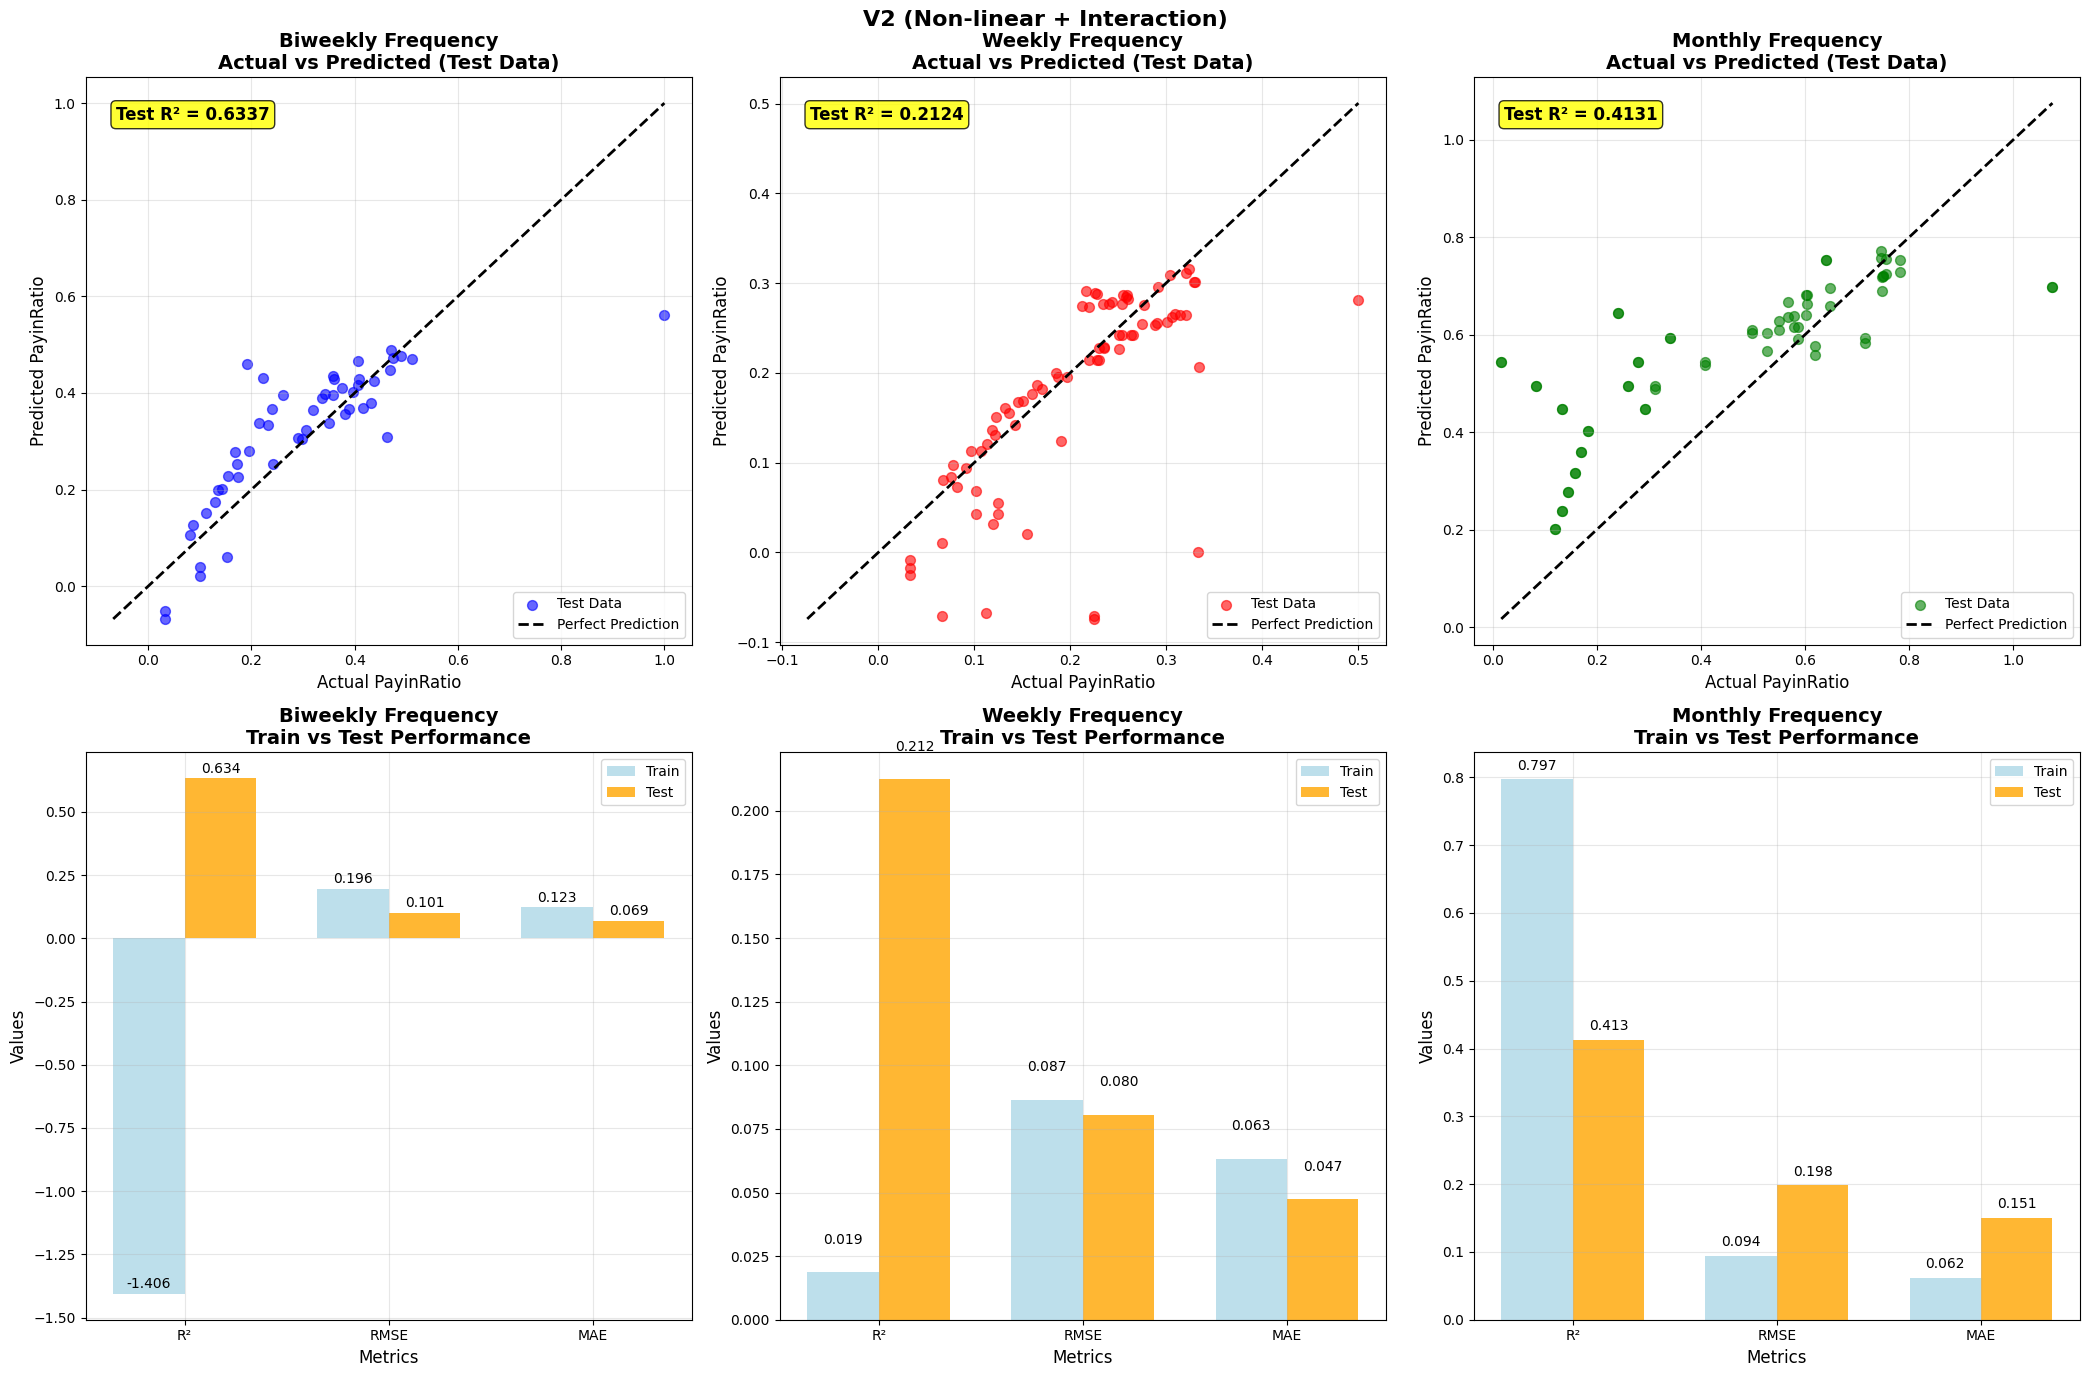


DETAILED MODEL PERFORMANCE SUMMARY
  Frequency Dataset Size Train Size Test Size  Train R²  Test R²  Train RMSE  \
0  Biweekly         None       None      None   -1.4062   0.6337      0.1965   
1    Weekly         None       None      None    0.0188   0.2124      0.0865   
2   Monthly         None       None      None    0.7971   0.4131      0.0937   

   Test RMSE  Train MAE  Test MAE  Overfitting  
0     0.1009     0.1226    0.0685      -2.0399  
1     0.0805     0.0634    0.0473      -0.1936  
2     0.1982     0.0621    0.1507       0.3840  

FEATURE IMPORTANCE ANALYSIS

Biweekly Frequency:
  Model Equation: PayinRatio = 0.5973 + -0.0353*InstallmentNumber + -0.7123*FPDFA_rate + 0.0004*InstallmentNumber_sq + 0.0078*Inst_x_FPDFA_rate
  InstallmentNumber coefficient: -0.0353
  FPDFA_rate coefficient: -0.7123
  InstallmentNumber_sq coefficient: 0.0004
  Inst_x_FPDFA_rate coefficient: 0.0078

Weekly Frequency:
  Model Equation: PayinRatio = 0.3903 + -0.0229*InstallmentNumber + -0.5655*

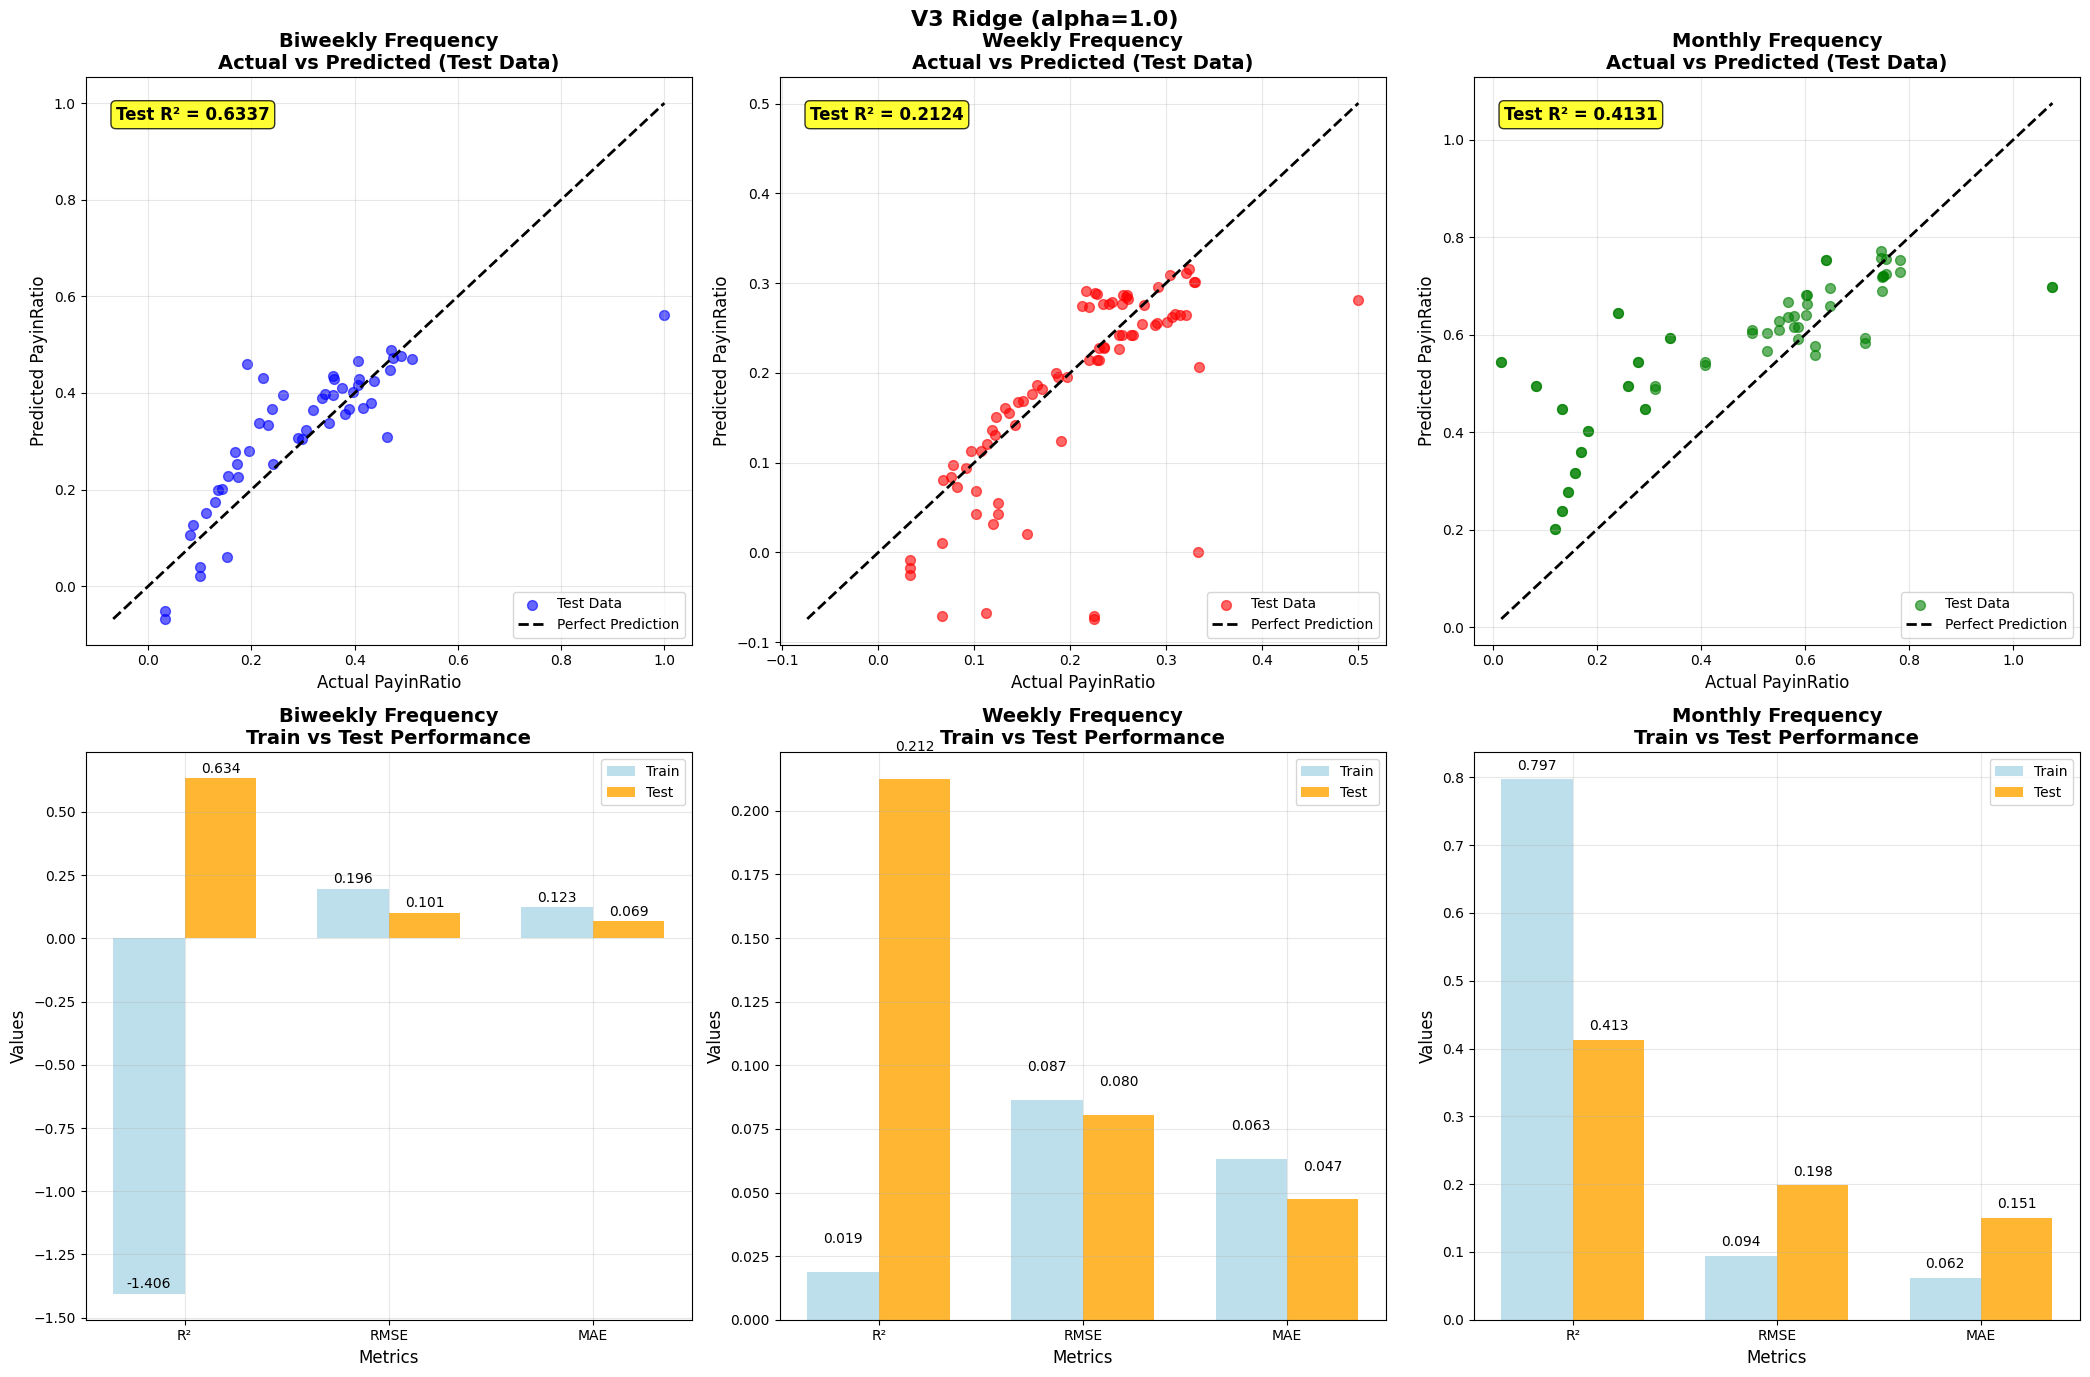


DETAILED MODEL PERFORMANCE SUMMARY
  Frequency Dataset Size Train Size Test Size  Train R²  Test R²  Train RMSE  \
0  Biweekly         None       None      None   -1.4062   0.6337      0.1965   
1    Weekly         None       None      None    0.0188   0.2124      0.0865   
2   Monthly         None       None      None    0.7971   0.4131      0.0937   

   Test RMSE  Train MAE  Test MAE  Overfitting  
0     0.1009     0.1226    0.0685      -2.0399  
1     0.0805     0.0634    0.0473      -0.1936  
2     0.1982     0.0621    0.1507       0.3840  

FEATURE IMPORTANCE ANALYSIS


In [16]:
# Visualize available regression results using the utility function
try:
    if 'model_results_v2' in locals() and model_results_v2:
        plot_model_results(model_results_v2, title='V2 (Non-linear + Interaction)')
    if 'ridge_results_v3' in locals() and ridge_results_v3:
        plot_model_results(ridge_results_v3, title='V3 Ridge (alpha=1.0)')
    if (('model_results' not in locals() or not model_results) and
        ('time_split_results' not in locals() or not time_split_results) and
        ('model_results_v2' not in locals() or not model_results_v2)):
        print('No results dicts found. Run the modeling cells first.')
except NameError as e:
    print(f'Variable missing: {e}. Run the corresponding modeling cell and retry.')



### GAM Model -- build model for both installmentNumber and FPDFA

In [ ]:
def time_split(df, train_start, train_end, test_start, test_end):
    train_mask = (df['OrigMonth'] >= train_start) & (df['OrigMonth'] <= train_end)
    test_mask  = (df['OrigMonth'] >= test_start)  & (df['OrigMonth'] <= test_end)
    
    train_df = df[train_mask].copy()
    test_df  = df[test_mask].copy()
    return train_df, test_df


In [15]:
comprehensive_datasets['Biweekly']['OrigMonth']


363    2024-08
364    2024-08
365    2024-08
366    2024-08
367    2024-08
        ...   
808    2025-10
809    2025-10
810    2025-10
811    2025-10
812    2025-11
Name: OrigMonth, Length: 450, dtype: object

In [16]:
print(comprehensive_datasets['Monthly']['OrigMonth'])
print(comprehensive_datasets['Weekly']['OrigMonth'])

178    2024-08
179    2024-08
180    2024-08
181    2024-08
182    2024-08
        ...   
622    2025-09
623    2025-10
624    2025-10
625    2025-10
626    2025-10
Name: OrigMonth, Length: 449, dtype: object
295    2024-08
296    2024-08
297    2024-08
298    2024-08
299    2024-08
        ...   
725    2025-10
726    2025-10
727    2025-10
728    2025-10
729    2025-10
Name: OrigMonth, Length: 435, dtype: object


In [17]:
date_windows = {
    "Biweekly": {
        "train_start": "2024-08-01",
        "train_end":   "2025-05-01",
        "test_start":  "2025-06-01",
        "test_end":    "2025-10-01"
    },
    "Weekly": {
        "train_start": "2024-08-01",
        "train_end":   "2025-05-01",
        "test_start":  "2025-06-01",
        "test_end":    "2025-10-01"
    },
    "Monthly": {
        "train_start": "2024-08-01",
        "train_end":   "2025-05-01",
        "test_start":  "2025-06-01",
        "test_end":    "2025-10-01"
    }
}


In [47]:
from pygam import LinearGAM, s

models = {}
results = {}

for freq, df_freq in comprehensive_datasets.items():
    print(f"--- Training model for {freq} ---")

    window = date_windows[freq]

    train_df, test_df = time_split(
        df_freq,
        train_start=window["train_start"],
        train_end=window["train_end"],
        test_start=window["test_start"],
        test_end=window["test_end"]
    )

    # Prepare X and y
    X_train = train_df[['InstallmentNumber', 'FPDFA_rate']]
    y_train = train_df['PayinRatio']

    X_test = test_df[['InstallmentNumber', 'FPDFA_rate']]
    y_test = test_df['PayinRatio']

    # Fit GAM
    gam = LinearGAM(
        s(0, n_splines=10) +   # InstallmentNumber
        s(1, n_splines=10)     # FPDFA_rate
    ).fit(X_train, y_train)

    # Store model
    models[freq] = gam

    # Evaluate
    preds = gam.predict(X_test)
    r2 = gam.statistics_['pseudo_r2']
    rmse = ((preds - y_test)**2).mean() ** 0.5
    mae = (preds - y_test).abs().mean()

    results[freq] = {
        "Train_samples": len(train_df),
        "Test_samples": len(test_df),
        "R2": r2,
        "RMSE": rmse,
        "MAE": mae
    }


--- Training model for Biweekly ---
--- Training model for Weekly ---
--- Training model for Monthly ---


In [48]:
results

{'Biweekly': {'Train_samples': 333,
  'Test_samples': 49,
  'R2': OrderedDict([('explained_deviance', np.float64(0.8843683072295356)),
               ('McFadden', np.float64(0.11348722566196423)),
               ('McFadden_adj', np.float64(0.8864993771249592))]),
  'RMSE': np.float64(0.061177359842913816),
  'MAE': np.float64(0.04788307201223802)},
 'Weekly': {'Train_samples': 326,
  'Test_samples': 52,
  'R2': OrderedDict([('explained_deviance', np.float64(0.8293327315612636)),
               ('McFadden', np.float64(0.1684540150829071)),
               ('McFadden_adj', np.float64(0.831530855033492))]),
  'RMSE': np.float64(0.06672820583424112),
  'MAE': np.float64(0.043003914743651214)},
 'Monthly': {'Train_samples': 345,
  'Test_samples': 52,
  'R2': OrderedDict([('explained_deviance', np.float64(0.9159249638069128)),
               ('McFadden', np.float64(0.08127781329140593)),
               ('McFadden_adj', np.float64(0.9187034084053345))]),
  'RMSE': np.float64(0.1451533044134490

In [ ]:
# Choose frequency model
gam_trial = gam['Biweekly']  # or 'Weekly', 'Monthly'

# Features: [InstallmentNumber, PDFA_rate]
X_new = np.array([[8, 0.18]], dtype=float)

y_pred = gam.predict(X_new)[0]                     # point estimate
ci_low, ci_high = gam.prediction_intervals(X_new, width=0.95)[0]  # 95% CI


NameError: name 'gam' is not defined

### Visualizing and model performances summary

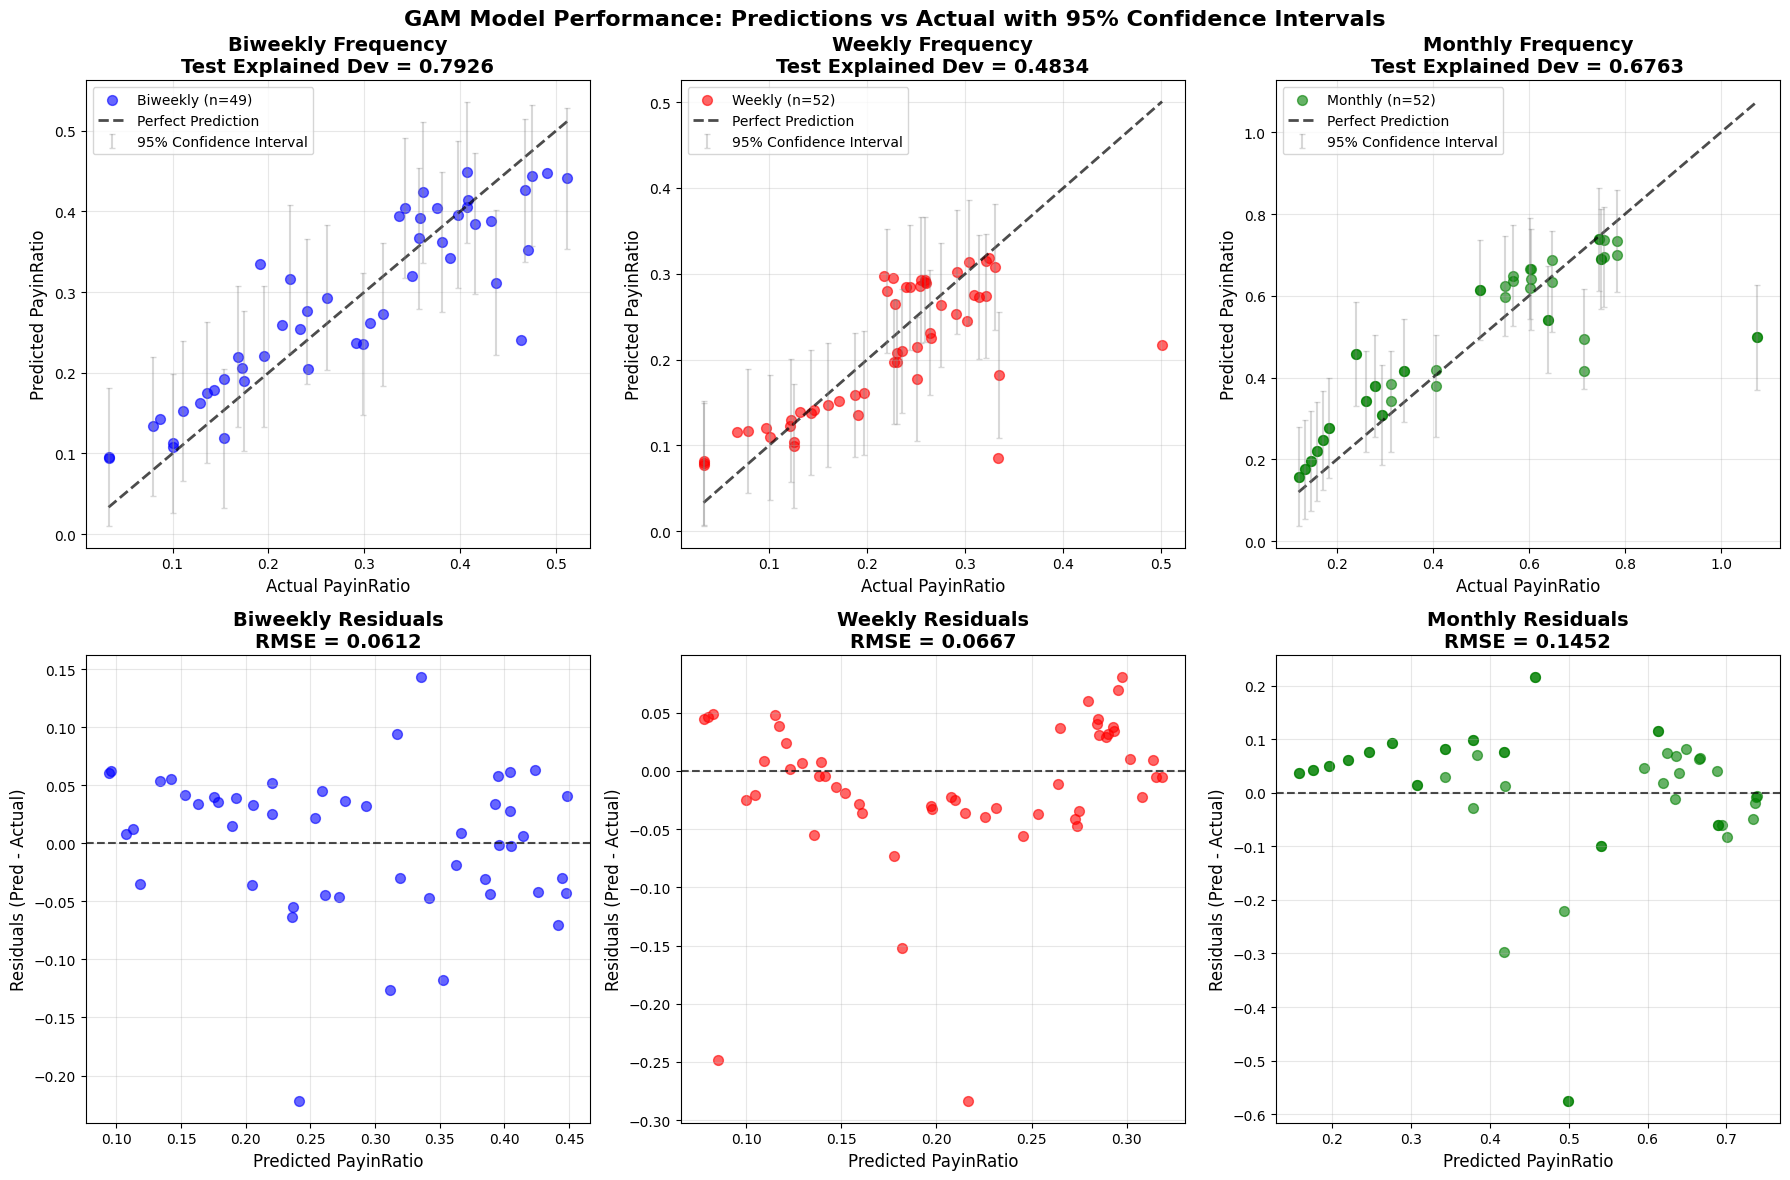


GAM MODEL PERFORMANCE SUMMARY
  Frequency  Train_Pseudo_R²  Train_McFadden  Train_Deviance  \
0  Biweekly           0.8844          0.1135        323.1607   
1    Weekly           0.8293          0.1685        315.4465   
2   Monthly           0.9159          0.0813        335.1129   

   Test_Standard_R²  Test_Pseudo_R²  Test_Explained_Dev    RMSE     MAE  \
0            0.7926          0.7926              0.7926  0.0612  0.0479   
1            0.4834          0.4834              0.4834  0.0667  0.0430   
2            0.6763          0.6763              0.6763  0.1452  0.0924   

   CI_Coverage  Avg_CI_Width  
0       0.8980        0.1755  
1       0.9038        0.1450  
2       0.8846        0.2473  

DETAILED DEVIANCE BREAKDOWN

Biweekly Frequency:
  Total Deviance (test):     0.88
  Residual Deviance (test):  0.18
  Null Deviance (test):      0.88
  Explained Deviance (test): 0.7926
  Standard R² (test):        0.7926
  GAM Pseudo R² (test):      0.7926

Weekly Frequency:
  Total 

In [50]:
# Enhanced visualization for GAM predictions with confidence intervals
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

def create_gam_prediction_plots(models, comprehensive_datasets, date_windows):
    """
    Create comprehensive prediction vs actual plots with confidence intervals
    for GAM models across different loan frequencies.
    """
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    colors = {'Biweekly': 'blue', 'Weekly': 'red', 'Monthly': 'green'}
    
    all_results = {}
    
    for i, (freq, model) in enumerate(models.items()):
        ax = axes[i]
        
        # Get the corresponding dataset and date window
        df_freq = comprehensive_datasets[freq]
        window = date_windows[freq]
        
        # Recreate the train/test split to get predictions with confidence intervals
        def time_split(df, train_start, train_end, test_start, test_end):
            train_mask = (df['OrigMonth'] >= train_start) & (df['OrigMonth'] <= train_end)
            test_mask  = (df['OrigMonth'] >= test_start)  & (df['OrigMonth'] <= test_end)
            return df[train_mask].copy(), df[test_mask].copy()
        
        train_df, test_df = time_split(
            df_freq,
            train_start=window["train_start"],
            train_end=window["train_end"],
            test_start=window["test_start"],
            test_end=window["test_end"]
        )
        
        # Prepare test data
        X_test = test_df[['InstallmentNumber', 'FPDFA_rate']]
        y_test = test_df['PayinRatio']
        
        # Get predictions and confidence intervals
        predictions = model.predict(X_test)
        confidence_intervals = model.prediction_intervals(X_test, width=0.95)
        
        # Calculate proper GAM test metrics
        # 1. Standard R² for test set (comparing to linear relationship)
        test_r2_standard = r2_score(y_test, predictions)
        
        # 2. Calculate test deviance explained (GAM-specific)
        # Total deviance = sum of squared deviations from mean
        total_deviance = np.sum((y_test - y_test.mean()) ** 2)
        # Residual deviance = sum of squared residuals
        residual_deviance = np.sum((y_test - predictions) ** 2)
        # Test explained deviance ratio
        test_explained_deviance = 1 - (residual_deviance / total_deviance)
        
        # 3. For comparison: what would null deviance be (just predicting mean)?
        null_predictions = np.full_like(y_test, y_test.mean())
        null_deviance = np.sum((y_test - null_predictions) ** 2)
        
        # 4. GAM pseudo R² for test (more appropriate than standard R²)
        test_pseudo_r2 = 1 - (residual_deviance / null_deviance)
        
        # Create scatter plot
        ax.scatter(y_test, predictions, alpha=0.6, color=colors[freq], s=50, 
                  label=f'{freq} (n={len(y_test)})')
        
        # Add perfect prediction line
        min_val = min(y_test.min(), predictions.min())
        max_val = max(y_test.max(), predictions.max())
        ax.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2, 
               alpha=0.7, label='Perfect Prediction')
        
        # Add confidence interval visualization (error bars)
        lower_ci = confidence_intervals[:, 0]
        upper_ci = confidence_intervals[:, 1]
        
        # Sort by actual values for better visualization
        sort_idx = np.argsort(y_test.values)
        y_test_sorted = y_test.iloc[sort_idx]
        pred_sorted = predictions[sort_idx]
        lower_sorted = lower_ci[sort_idx]
        upper_sorted = upper_ci[sort_idx]
        
        # Add error bars for a subset of points to avoid overcrowding
        step = max(1, len(sort_idx) // 20)  # Show every nth point
        subset_idx = sort_idx[::step]
        
        ax.errorbar(y_test.iloc[subset_idx], predictions[subset_idx],
                   yerr=[predictions[subset_idx] - lower_ci[subset_idx],
                         upper_ci[subset_idx] - predictions[subset_idx]],
                   fmt='none', ecolor='gray', alpha=0.3, capsize=2,
                   label='95% Confidence Interval')
        
        # Formatting
        ax.set_xlabel('Actual PayinRatio', fontsize=12)
        ax.set_ylabel('Predicted PayinRatio', fontsize=12)
        ax.set_title(f'{freq} Frequency\nTest Explained Dev = {test_explained_deviance:.4f}', 
                    fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.legend()
        
        # Store results (including corrected GAM-specific metrics)
        all_results[freq] = {
            'actual': y_test.values,
            'predicted': predictions,
            'lower_ci': lower_ci,
            'upper_ci': upper_ci,
            'test_r2_standard': test_r2_standard,
            'test_explained_deviance': test_explained_deviance,
            'test_pseudo_r2': test_pseudo_r2,
            'train_deviance': model.statistics_['deviance'],
            'train_pseudo_r2': model.statistics_['pseudo_r2']['explained_deviance'],
            'train_mcfadden': model.statistics_['pseudo_r2']['McFadden'],
            'train_mcfadden_adj': model.statistics_['pseudo_r2']['McFadden_adj'],
            'total_deviance': total_deviance,
            'residual_deviance': residual_deviance,
            'null_deviance': null_deviance,
            'rmse': np.sqrt(((predictions - y_test) ** 2).mean()),
            'mae': np.abs(predictions - y_test).mean()
        }
    
    # Create residuals plots in the second row
    for i, freq in enumerate(models.keys()):
        ax = axes[i + 3]
        results = all_results[freq]
        
        residuals = results['predicted'] - results['actual']
        
        # Residuals vs Predicted
        ax.scatter(results['predicted'], residuals, alpha=0.6, 
                  color=colors[freq], s=50)
        ax.axhline(y=0, color='black', linestyle='--', alpha=0.7)
        ax.set_xlabel('Predicted PayinRatio', fontsize=12)
        ax.set_ylabel('Residuals (Pred - Actual)', fontsize=12)
        ax.set_title(f'{freq} Residuals\nRMSE = {results["rmse"]:.4f}', 
                    fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
    
    plt.suptitle('GAM Model Performance: Predictions vs Actual with 95% Confidence Intervals', 
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics with corrected GAM-specific metrics
    print("\n" + "="*80)
    print("GAM MODEL PERFORMANCE SUMMARY")
    print("="*80)
    
    summary_data = []
    for freq, results in all_results.items():
        # Calculate confidence interval coverage
        within_ci = ((results['actual'] >= results['lower_ci']) & 
                     (results['actual'] <= results['upper_ci'])).mean()
        
        summary_data.append({
            'Frequency': freq,
            'Train_Pseudo_R²': results['train_pseudo_r2'],
            'Train_McFadden': results['train_mcfadden'],
            'Train_Deviance': results['train_deviance'],
            'Test_Standard_R²': results['test_r2_standard'],
            'Test_Pseudo_R²': results['test_pseudo_r2'], 
            'Test_Explained_Dev': results['test_explained_deviance'],
            'RMSE': results['rmse'],
            'MAE': results['mae'],
            'CI_Coverage': within_ci,
            'Avg_CI_Width': (results['upper_ci'] - results['lower_ci']).mean()
        })
    
    summary_df = pd.DataFrame(summary_data)
    print(summary_df.round(4))
    
    print(f"\n" + "="*80)
    print("DETAILED DEVIANCE BREAKDOWN")
    print("="*80)
    for freq, results in all_results.items():
        print(f"\n{freq} Frequency:")
        print(f"  Total Deviance (test):     {results['total_deviance']:.2f}")
        print(f"  Residual Deviance (test):  {results['residual_deviance']:.2f}")
        print(f"  Null Deviance (test):      {results['null_deviance']:.2f}")
        print(f"  Explained Deviance (test): {results['test_explained_deviance']:.4f}")
        print(f"  Standard R² (test):        {results['test_r2_standard']:.4f}")
        print(f"  GAM Pseudo R² (test):      {results['test_pseudo_r2']:.4f}")
    
    print(f"\nMetric Explanations:")
    print(f"- Standard R²: Traditional R² comparing predictions to actual values")
    print(f"- Pseudo R²: GAM-specific R² accounting for smoothing penalties") 
    print(f"- Explained Deviance: Proportion of total deviance explained (1 - residual/total)")
    print(f"- Train metrics use training data; Test metrics use out-of-sample predictions")
    print(f"- CI_Coverage: Should be around 0.95 for well-calibrated 95% confidence intervals")
    
    return all_results

# Create the visualization
if 'models' in locals() and models:
    gam_results = create_gam_prediction_plots(models, comprehensive_datasets, date_windows)
else:
    print("Please run the GAM model training cell first to generate the models.")

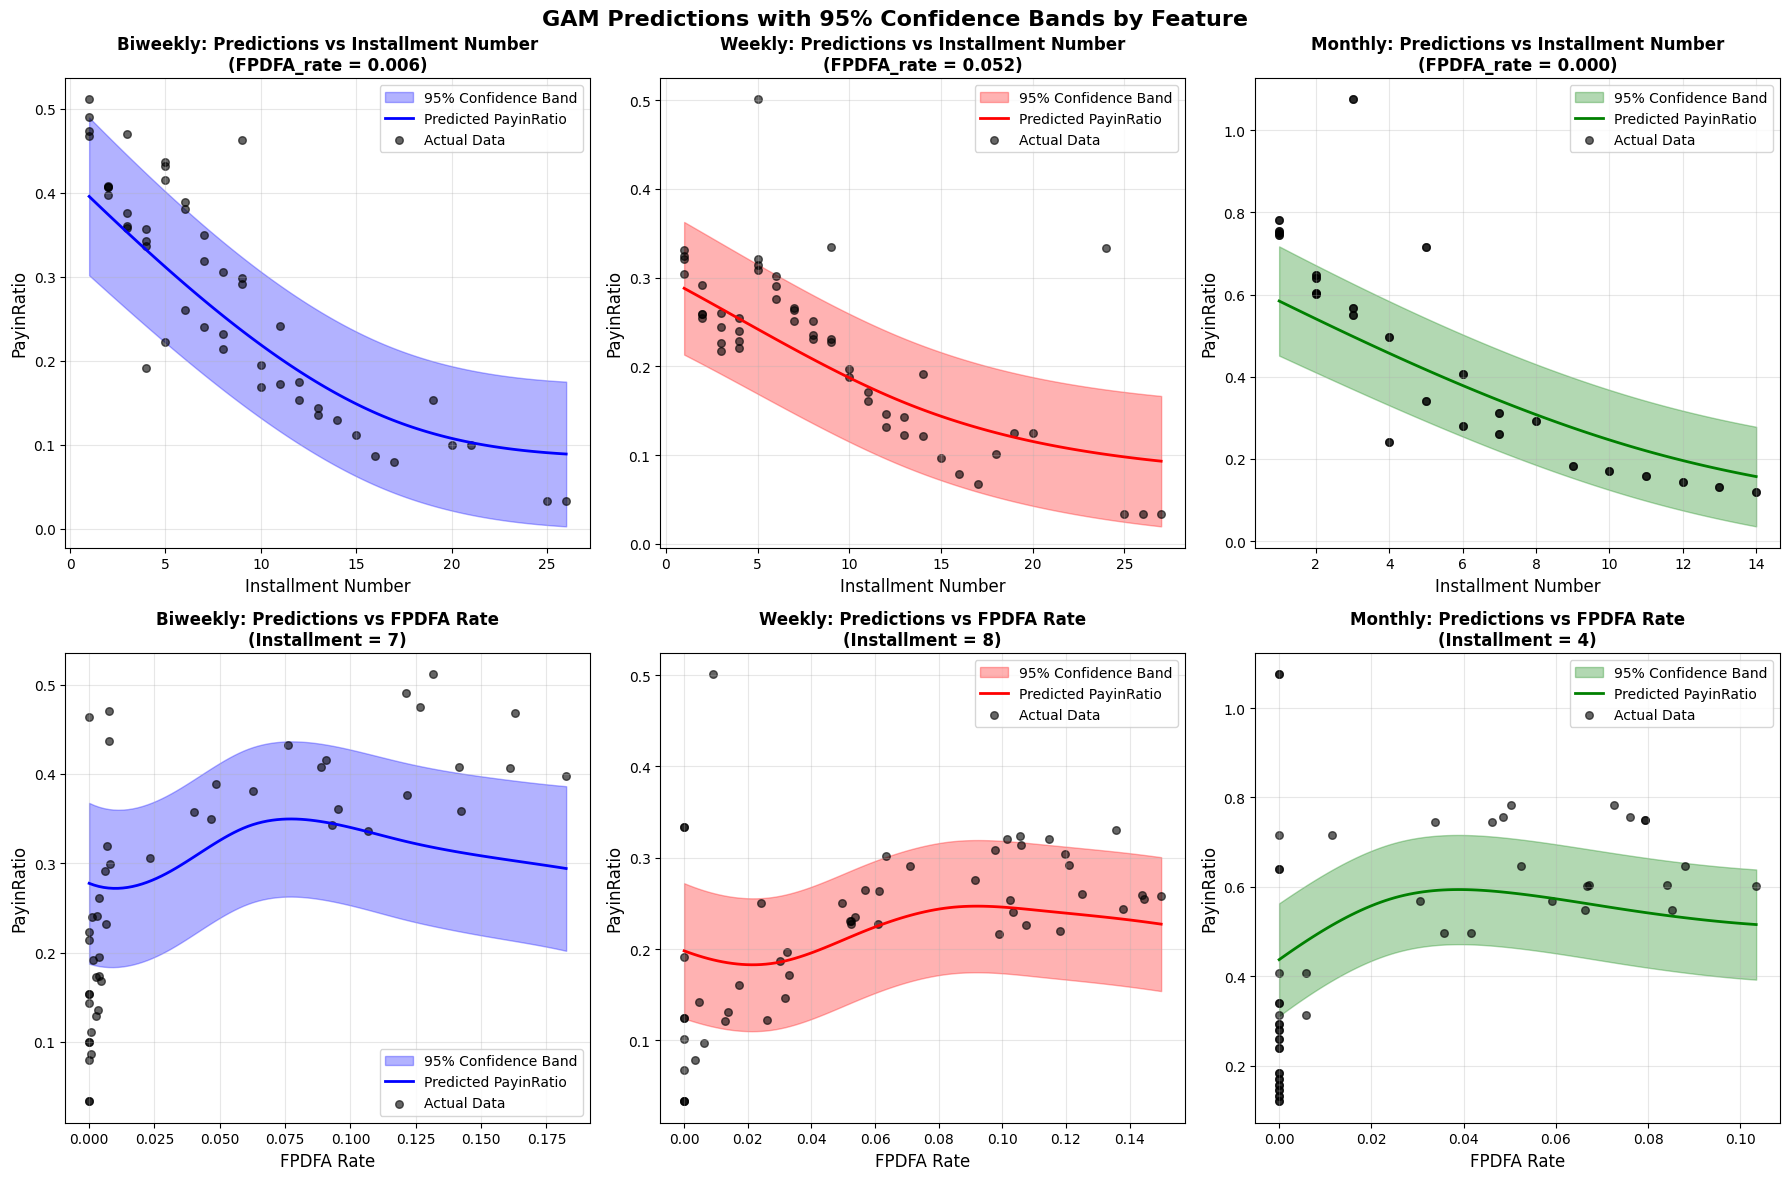

In [51]:
# Alternative visualization: Confidence bands for predictions
def create_confidence_band_plots(models, comprehensive_datasets, date_windows):
    """
    Create prediction plots with confidence bands showing uncertainty across
    the range of each feature (InstallmentNumber and FPDFA_rate).
    """
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    colors = {'Biweekly': 'blue', 'Weekly': 'red', 'Monthly': 'green'}
    
    for i, (freq, model) in enumerate(models.items()):
        # Get the corresponding dataset
        df_freq = comprehensive_datasets[freq]
        window = date_windows[freq]
        
        # Recreate test data
        def time_split(df, train_start, train_end, test_start, test_end):
            train_mask = (df['OrigMonth'] >= train_start) & (df['OrigMonth'] <= train_end)
            test_mask  = (df['OrigMonth'] >= test_start)  & (df['OrigMonth'] <= test_end)
            return df[train_mask].copy(), df[test_mask].copy()
        
        train_df, test_df = time_split(
            df_freq,
            train_start=window["train_start"],
            train_end=window["train_end"],
            test_start=window["test_start"],
            test_end=window["test_end"]
        )
        
        # Plot 1: Predictions vs InstallmentNumber (top row)
        ax1 = axes[0, i]
        
        # Create a range of InstallmentNumber values
        inst_range = np.linspace(test_df['InstallmentNumber'].min(), 
                                test_df['InstallmentNumber'].max(), 100)
        
        # Use median FPDFA_rate for this visualization
        median_fpd = test_df['FPDFA_rate'].median()
        
        # Create prediction grid
        X_grid = np.column_stack([inst_range, np.full(len(inst_range), median_fpd)])
        
        # Get predictions and confidence intervals
        pred_grid = model.predict(X_grid)
        ci_grid = model.prediction_intervals(X_grid, width=0.95)
        
        # Plot confidence band
        ax1.fill_between(inst_range, ci_grid[:, 0], ci_grid[:, 1], 
                        alpha=0.3, color=colors[freq], label='95% Confidence Band')
        
        # Plot prediction line
        ax1.plot(inst_range, pred_grid, color=colors[freq], linewidth=2, 
                label='Predicted PayinRatio')
        
        # Scatter actual test data
        ax1.scatter(test_df['InstallmentNumber'], test_df['PayinRatio'], 
                   alpha=0.6, color='black', s=30, label='Actual Data')
        
        ax1.set_xlabel('Installment Number', fontsize=12)
        ax1.set_ylabel('PayinRatio', fontsize=12)
        ax1.set_title(f'{freq}: Predictions vs Installment Number\n(FPDFA_rate = {median_fpd:.3f})', 
                     fontsize=12, fontweight='bold')
        ax1.grid(True, alpha=0.3)
        ax1.legend()
        
        # Plot 2: Predictions vs FPDFA_rate (bottom row)
        ax2 = axes[1, i]
        
        # Create a range of FPDFA_rate values
        fpd_range = np.linspace(test_df['FPDFA_rate'].min(), 
                               test_df['FPDFA_rate'].max(), 100)
        
        # Use median InstallmentNumber for this visualization
        median_inst = test_df['InstallmentNumber'].median()
        
        # Create prediction grid
        X_grid2 = np.column_stack([np.full(len(fpd_range), median_inst), fpd_range])
        
        # Get predictions and confidence intervals
        pred_grid2 = model.predict(X_grid2)
        ci_grid2 = model.prediction_intervals(X_grid2, width=0.95)
        
        # Plot confidence band
        ax2.fill_between(fpd_range, ci_grid2[:, 0], ci_grid2[:, 1], 
                        alpha=0.3, color=colors[freq], label='95% Confidence Band')
        
        # Plot prediction line
        ax2.plot(fpd_range, pred_grid2, color=colors[freq], linewidth=2, 
                label='Predicted PayinRatio')
        
        # Scatter actual test data
        ax2.scatter(test_df['FPDFA_rate'], test_df['PayinRatio'], 
                   alpha=0.6, color='black', s=30, label='Actual Data')
        
        ax2.set_xlabel('FPDFA Rate', fontsize=12)
        ax2.set_ylabel('PayinRatio', fontsize=12)
        ax2.set_title(f'{freq}: Predictions vs FPDFA Rate\n(Installment = {median_inst:.0f})', 
                     fontsize=12, fontweight='bold')
        ax2.grid(True, alpha=0.3)
        ax2.legend()
    
    plt.suptitle('GAM Predictions with 95% Confidence Bands by Feature', 
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Create the confidence band visualization
if 'models' in locals() and models:
    create_confidence_band_plots(models, comprehensive_datasets, date_windows)
else:
    print("Please run the GAM model training cell first to generate the models.")